#Init

# Human Written Text vs. AI Generated Text
### INF582
Hugo BOUIGEON, Thomas LI, Jules POTEL

In [1]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 829.4 kB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Modify
!ls "/content/drive/My Drive/Colab Notebooks/nlp_project"

 INF582_final_project.ipynb	       INF582_shap.ipynb
'INF582_hugging_face_gpt2 (1).ipynb'   test_set.json
 INF582_hybrid_model.ipynb	       train_set.json


In [12]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Uploading Dataset

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import csv
from sklearn.metrics import classification_report

import datasets

import transformers
print(transformers.__version__)

4.26.1


In [14]:
# Modify
ROOT_PATH = "/content/drive/My Drive/Colab Notebooks/nlp_project/"

In [15]:
# Read The data
training_set = pd.read_json(ROOT_PATH + 'train_set.json')
test_set = pd.read_json(ROOT_PATH + 'test_set.json')
test_set['label'] = 0 #these are fake labels, it is just easier this way to tokenize it

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_set, test_size=0.2, shuffle=True, stratify=training_set['label'])

from datasets import Dataset
train_dataset = Dataset.from_pandas(train_set)
val_dataset = Dataset.from_pandas(val_set)
test_dataset = Dataset.from_pandas(test_set)

dataset = datasets.DatasetDict({"train":train_dataset,"val":val_dataset, "test":test_dataset})

In [16]:
import random
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

#Config

In [17]:
model_checkpoint =  "roberta-base"
batch_size = 16

#Preprocessing

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [19]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

#Loading Berta

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-classification",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

def compute_metrics(eval_pred):
    output = {}
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    output['accuracy'] = np.mean(predictions == labels)
    return output


In [21]:
# Load an already trained model

# trained_model_url = "ThomasLI/distilbert-base-uncased-finetuned-classification"
trained_model_url = "ThomasLI/roberta-base-finetuned-classification"
model = AutoModelForSequenceClassification.from_pretrained(trained_model_url)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/hugobgn/roberta-base-finetuned-classification into local empty directory.


In [22]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.2635610103607178,
 'eval_accuracy': 0.9,
 'eval_runtime': 16.7253,
 'eval_samples_per_second': 47.832,
 'eval_steps_per_second': 2.989}

# Additional features

In [23]:
def len_feature(x):
  return len(x)

def n_sentences(x):
  return x.count('.')      # counting dots ie sentences

def n_upper(x):
  return sum(x.count(e) for e in "ABCDEFGHIJKLMNOPQRSTUVWXYZ")

#Creating Datasets

In [24]:
#for training:
#getting predictions from roberta:
roberta_preds_train = trainer.predict(encoded_dataset["train"])
roberta_preds_val = trainer.predict(encoded_dataset["val"])

#trainset
dft = pd.DataFrame(encoded_dataset["train"])

dft['len'] = dft["input_ids"].apply(len_feature)
dft['n_sentences'] = dft["text"].apply(n_sentences)
dft['n_upper'] = dft["text"].apply(n_upper)
dft['roberta_out_0'] = roberta_preds_train[0][:,0]
dft['roberta_out_1'] = roberta_preds_train[0][:,1]

#valset
dfv = pd.DataFrame(encoded_dataset["val"])

dfv['len'] = dfv["input_ids"].apply(len_feature)
dfv['n_sentences'] = dfv["text"].apply(n_sentences)
dfv['n_upper'] = dfv["text"].apply(n_upper)
dfv['roberta_out_0'] = roberta_preds_val[0][:,0]
dfv['roberta_out_1'] = roberta_preds_val[0][:,1]

#full trainset
df_train = pd.concat([dft,dfv])

X_train = df_train[['len',	'roberta_out_0',	'roberta_out_1',	'n_sentences','n_upper']]
y_train = df_train["label"]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3200
  Batch size = 16


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 800
  Batch size = 16


In [26]:
X_train

,len,roberta_out_0,roberta_out_1,n_sentences,n_upper
0,76,0.726543,-0.903947,3,5
1,41,-1.409547,1.155407,3,14
2,248,-0.675582,0.469182,8,52
3,58,-1.640320,1.473976,4,12
4,73,-1.419043,1.233697,3,10
...,...,...,...,...,...
795,183,-2.309361,2.050061,7,37
796,73,2.369995,-2.971023,3,8
797,205,2.553886,-3.347746,9,58
798,58,2.690254,-3.429271,3,0


In [25]:
#for testset:
#getting predictions from roberta:
roberta_preds_test = trainer.predict(encoded_dataset["test"])

testdf = pd.DataFrame(encoded_dataset["test"])

testdf['len'] = testdf["input_ids"].apply(len_feature)
testdf['n_sentences'] = testdf["text"].apply(n_sentences)
testdf['n_upper'] = testdf["text"].apply(n_upper)
testdf['roberta_out_0'] = roberta_preds_test[0][:,0]
testdf['roberta_out_1'] = roberta_preds_test[0][:,1]

X_test = testdf[['len',	'roberta_out_0',	'roberta_out_1',	'n_sentences','n_upper']]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, text. If id, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 16


#Training Model

In [27]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import GridSearchCV

In [28]:
final_model = make_pipeline(StandardScaler(),GradientBoostingClassifier(n_estimators = 150))

results = cross_validate(final_model,X_train,y_train,scoring="accuracy")
print("accuracy: ", np.mean(results['test_score']))

accuracy:  0.9335000000000001


In [29]:
final_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=150))])

#Submission

In [30]:
preds = final_model.predict(X_test)

In [31]:
def submit(my_pred, name = 'last_submission'):
  # Write predictions to a file
  with open(name + ".csv", "w") as pred:
      csv_out = csv.writer(pred)
      csv_out.writerow(['id','label'])
      for i, row in enumerate(my_pred):
          csv_out.writerow([i, row])

In [32]:
name = "hybrid_model"
submit(preds, name = name)

#Appendix: featur importance on random forest

In [33]:
forest = RandomForestClassifier()

results = cross_validate(forest,X_train,y_train,scoring="accuracy")
print("accuracy: ", np.mean(results['test_score']))

forest.fit(X_train,y_train)


accuracy:  0.92975


RandomForestClassifier()

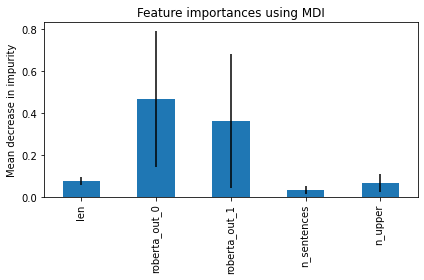

In [34]:
# visual

feature_names = ["len",	"roberta_out_0",	"roberta_out_1",	"n_sentences",	"n_upper"]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()